In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
!pwd

/home/walml/repos/zoobot


In [58]:
!git pull

Already up-to-date.


In [59]:
import matplotlib

In [60]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config


In [61]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [62]:
os.chdir('/home/walml/repos/zoobot')

In [63]:
# start = 50
# end = 60
# start = 0
# end=5

### Load the (latest) model under `model_name` folder in `results_dir`

In [64]:
# catalog_loc = 'data/latest_labelled_catalog.csv
catalog_loc = 'data/decals/decals_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/decals/png_native' + x[32:])


# catalog_loc = 'data/decals/temp_calibration_catalog.csv'
# catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog

model_name = 'latest_offline'

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [65]:


# Figures will be saved to here

analysis_dir = 'analysis/multiquestion'
save_dir = f'{analysis_dir}/{model_name}'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# results_dir = '/home/walml/repos/zoobot/data/experiments/live/no_cutouts/iteration_0'
# results_dir = '/home/walml/repos/zoobot/results/smooth_or_featured_offline'
# results_dir = '/home/walml/repos/zoobot/results/debug'
# results_dir = '/home/walml/repos/zoobot/results/latest/effnetB0_decals_mf_244px_256init_10k'
# results_dir = '/home/walml/repos/zoobot/results/latest/latest_offline_full'

# two identical models, trained at different times
results_dir = '/home/walml/repos/zoobot/results/latest/latest_offline_10k_x2val_b256'
# results_dir = '/home/walml/repos/zoobot/results/latest/latest_offline_10k_x2val'

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
    'bar',
    'bulge-size'
]

# decals cols
version = 'decals'
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

# gz2 cols
# version = 'gz2'
# label_cols = [
#     'smooth-or-featured_smooth',
#     'smooth-or-featured_featured-or-disk',
#     'has-spiral-arms_yes',
#     'has-spiral-arms_no',
#     'bar_yes',
#     'bar_no',
#     'bulge-size_dominant',
#     'bulge-size_obvious',
#     'bulge-size_just-noticeable',
#     'bulge-size_no'
# ]



schema = losses.Schema(label_cols, questions, version=version)

batch_size = 16
initial_size = 256
final_size = 224
channels = 3

n_samples = 15

# if loading single test tfrecord
# tfrecord_locs = [f'data/decals/shards/multilabel_{img_size}/eval/s{initial_size}_shard_0.tfrecord']
# tfrecord_locs = ['data/decals/shards/multilabel_master_256/train/s256_shard_0.tfrecord']
# tfrecord_locs = glob.glob(f'/media/walml/beta/decals/multilabel_master_{initial_size}/train/*.tfrecord')[start:end]
# tfrecord_locs = glob.glob(f'/home/walml/repos/zoobot/data/decals/shards/decals_multiq_{initial_size}_sim_init_2500_featp4/train_shards/*.tfrecord')[start:end]

# for all labelled decals galaxies
# train_locs = glob.glob(f'/home/walml/repos/zoobot/data/decals/shards/decals_multiq_{initial_size}/train_shards/*.tfrecord')
# eval_locs = glob.glob(f'/home/walml/repos/zoobot/data/decals/shards/decals_multiq_{initial_size}/eval_shards/*.tfrecord')
# tfrecord_locs = train_locs + eval_locs

# for all decals galaxies after filter
train_locs = glob.glob(f'/home/walml/repos/zoobot/data/decals/shards/multilabel_master_filtered_{initial_size}/train/*.tfrecord')
eval_locs = glob.glob(f'/home/walml/repos/zoobot/data/decals/shards/multilabel_master_filtered_{initial_size}/eval/*.tfrecord')
tfrecord_locs = eval_locs

# tfrecord_locs = train_locs[:1]

# for calibration dr5 galaxies
# eval_locs = glob.glob(f'/home/walml/repos/zoobot/data/decals/shards/temp_calibration_shards_feat/train/*.tfrecord')
# tfrecord_locs = eval_locs

# for 10k labelled/filtered GZ2 galaxies
# train_locs = glob.glob(f'/home/walml/repos/zoobot/data/gz2/shards/all_featp5_facep5_sim_{initial_size}/train_shards/*.tfrecord')
# eval_locs = glob.glob(f'/home/walml/repos/zoobot/data/gz2/shards/all_featp5_facep5_sim_{initial_size}/eval_shards/*.tfrecord')
# tfrecord_locs = train_locs + eval_locs

print(tfrecord_locs)
eval_config = run_estimator_config.get_eval_config(tfrecord_locs, label_cols, batch_size, initial_size, final_size, channels)
# print(eval_config.greyscale)
# print(eval_config.permute_channels)
eval_config.drop_remainder = False
dataset = input_utils.get_input(config=eval_config)

feature_spec = input_utils.get_feature_spec({'id_str': 'string'})
id_str_dataset = input_utils.get_dataset(tfrecord_locs, feature_spec, batch_size=1, shuffle=False, repeat=False, drop_remainder=False)
id_strs = [str(d['id_str'].numpy().squeeze())[2:-1] for d in id_str_dataset]
id_strs[:5]

# n = 0
# for batch in id_str_dataset:
#     for id_str in batch:
#         n+=1
# print(n)

# counter = Counter()
# n = 0
# for g_batch, y_batch in dataset:
# #     for g in g_batch:
# #         counter[g.numpy().sum()] += 1
#         n+=tf.shape(g_batch)[0]
# print(n)

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f2f671bd590>: (2, 3), bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f2f671bd590>: (4, 6), bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f2f671bd590>: (7, 11)}
['/home/walml/repos/zoobot/data/decals/shards/multilabel_master_filtered_256/eval/s256_shard_0.tfrecord']
loading filenames: <TensorSliceDataset shapes: (), types: tf.string>
16 16
loading filenames: <TensorSliceDataset shapes: (), types: tf.string>
1 1


['J143543.28+004315.8',
 'J101317.99+075217.3',
 'J095124.39+061959.2',
 'J141823.66+004355.6',
 'J002235.11+001734.5']

In [66]:
# fig, axes = plt.subplots(ncols=3)
# n=0
# for images, labels in dataset.take(3):
#     image = images[0]
#     axes[n].imshow(image.numpy().squeeze())
#     n+= 1

In [67]:
len(id_strs)

1000

In [68]:
# # if loading png

# print(catalog['file_loc'])
# assert all([os.path.isfile(x) for x in catalog['file_loc']])
# filenames = tf.constant(list(catalog['file_loc']), dtype=tf.string)
# dataset = tf.data.Dataset.from_tensor_slices(filenames)

# def parse_image(im):
#     im = tf.image.decode_png(im, channels=channels)
#     im = tf.image.convert_image_dtype(im, tf.float32)
#     im = tf.image.resize(im, [initial_size, initial_size])
#     return im


# # for im in dataset.take(1):
# #     print(im)

# # assert False

# dataset = dataset.map(tf.io.read_file)
# dataset = dataset.map(parse_image)

# config = default_estimator_params.get_eval_config(['do not use'], label_cols, batch_size, initial_size, final_size, channels)

# dataset = dataset.batch(batch_size)

# # for batch in dataset.take(1):
# #     print(tf.shape(batch))
# # #     plt.imshow(batch[0])


# # dataset = dataset.map(lambda x: check_shape(x))

# dataset = dataset.map(lambda x: input_utils.preprocess_images(x, config))


# # for batch in dataset.take(1):
# #     print(tf.shape(batch))
# #     plt.imshow(batch[0].numpy().squeeze())


# id_strs = catalog['iauname']



In [69]:
model = run_estimator_config.get_model(schema, final_size)

# checkpoint_dir = f'{results_dir}/estimators/models'
checkpoint_dir = f'{results_dir}/models'
print(checkpoint_dir)
load_status = model.load_weights(checkpoint_dir)



Name: smooth-or-featured, start 0, end 1
Name: has-spiral-arms, start 2, end 3
Name: bar, start 4, end 6
Name: bulge-size, start 7, end 11
[(0, 1), (2, 3), (4, 6), (7, 11)]
0 1
2 3
4 6
7 11
Name: smooth-or-featured, start 0, end 1
Name: has-spiral-arms, start 2, end 3
Name: bar, start 4, end 6
Name: bulge-size, start 7, end 11
[(0, 1), (2, 3), (4, 6), (7, 11)]
0 1
2 3
4 6
7 11
/home/walml/repos/zoobot/results/latest/latest_offline_10k_x2val_b256/models


In [70]:
# %timeit predictions = model.predict(dataset)

In [71]:
dataset

<MapDataset shapes: ((None, 224, 224, 1), (None, 12)), types: (tf.float32, tf.float32)>

In [72]:
# model.predict(dataset).shape

In [73]:
predictions = np.stack([model.predict(dataset) for n in range(n_samples)], axis=-1)

In [74]:
predictions.shape

(1000, 12, 15)

In [75]:
predictions[0]  # even w/ quite high dropout rates, the variation is still pretty small

array([[0.09030036, 0.14907221, 0.07054   , 0.14383334, 0.16671202,
        0.1653262 , 0.12858042, 0.08048473, 0.07143922, 0.10926156,
        0.07977725, 0.18934865, 0.10316043, 0.12728824, 0.11481953],
       [0.9096997 , 0.8509278 , 0.92946   , 0.85616666, 0.83328795,
        0.8346738 , 0.87141955, 0.91951525, 0.9285608 , 0.8907385 ,
        0.92022276, 0.81065136, 0.8968396 , 0.8727117 , 0.8851804 ],
       [0.92350745, 0.868437  , 0.9534146 , 0.82057524, 0.8293011 ,
        0.78471303, 0.8732895 , 0.91083854, 0.95423615, 0.910485  ,
        0.94906145, 0.769527  , 0.92936546, 0.8805978 , 0.9180815 ],
       [0.07649258, 0.13156298, 0.04658543, 0.17942469, 0.17069885,
        0.21528697, 0.12671043, 0.08916149, 0.04576379, 0.08951497,
        0.05093851, 0.23047295, 0.07063457, 0.11940225, 0.0819185 ],
       [0.5220789 , 0.62126756, 0.50431365, 0.44561246, 0.6179059 ,
        0.5886897 , 0.69512045, 0.5031505 , 0.6167795 , 0.5405424 ,
        0.62253016, 0.5824695 , 0.654737  , 

Text(0.5, 0, 'Mean smooth/featured std')

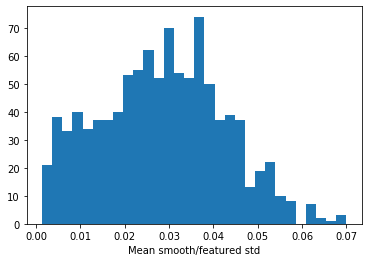

In [76]:
plt.hist(np.std(predictions[:, 0, :], axis=-1), bins=30)
plt.xlabel('Mean smooth/featured std')

In [77]:
# for batch_x, batch_y in dataset:
#     print(batch_y.numpy())
#     break

In [78]:
# labels = np.concatenate([batch_y for (_, batch_y) in test_dataset], axis=0)
# labels.shape

In [79]:
labels = catalog[label_cols].values

In [80]:
# fig, ax = plt.subplots()
# ax.hist(predictions[:, 0], alpha=0.5, label='Predictions', density=True)
# ax.hist(labels[:, 0] / labels[:, :2].sum(axis=1), alpha=0.5, label='Labels', density=True)
# plt.legend()

In [81]:
# print(predictions[:, 0].min(), labels[:, 0].min())
# print(predictions[:, 0].max(), labels[:, 0].max())

In [82]:
# acquisitions = acquisition_utils.mutual_info_acquisition_func_multiq(predictions, schema, retirement=40)
# acquisitions.shape
# acquisitions

# single_q_acquisitions = np.array(acquisition_utils.mutual_info_acquisition_func(predictions[:, 0], expected_votes=40))
# single_q_acquisitions[:5], acquisitions[0, :5], acquisitions[1, :5]  # smooth mutual acq should be identical, for both answers by symmmetry
# acquisitions[2, :5], acquisitions[3, :5]  # has-spiral-arms also by symmetry
# acquisitions[4, :5], acquisitions[5, :5], acquisitions[6, :5]  # but for spiral winding there are 3 answers so *not* identical
# predictions.shape, acquisitions.shape, len(id_strs)

In [83]:
predictions.shape, len(id_strs)

((1000, 12, 15), 1000)

In [84]:
predictions[0][0]

array([0.09030036, 0.14907221, 0.07054   , 0.14383334, 0.16671202,
       0.1653262 , 0.12858042, 0.08048473, 0.07143922, 0.10926156,
       0.07977725, 0.18934865, 0.10316043, 0.12728824, 0.11481953],
      dtype=float32)

In [85]:
def prediction_to_row(prediction, id_str):
    row = {
        'id_str': id_str
    }
    for n, col in enumerate(label_cols):
        answer = label_cols[n]
        row[answer + '_prediction'] = json.dumps(list(prediction[n].astype(float)))
#         row[answer + '_acquisition'] = acquisition[n]
        row[answer + '_prediction_mean'] = float(prediction[n].mean())
#         row[answer + '_acquisition'] = acquisition[n]
#         row['total_acquisition'] = acquisition.sum()
    return row

In [86]:
def all_to_row(prediction, acquisition, id_str):
    row = {
        'id_str': id_str
    }
    for n, col in enumerate(label_cols):
        answer = label_cols[n]
        row[answer + '_prediction'] = prediction[n]
#         row[answer + '_acquisition'] = acquisition[n]
        row[answer + '_prediction_mean'] = float(prediction[n].mean())
#         row[answer + '_acquisition'] = acquisition[n]
#         row['total_acquisition'] = acquisition.sum()
    return row

In [87]:
data = [prediction_to_row(predictions[n], id_strs[n]) for n in range(len(predictions))]
# data = [all_to_row(predictions[n], acquisitions[n], id_strs[n]) for n in range(len(predictions))]
predictions_df = pd.DataFrame(data)

In [88]:
len(predictions_df)

1000

In [89]:
predictions_df.head()

,id_str,smooth-or-featured_smooth_prediction,smooth-or-featured_smooth_prediction_mean,smooth-or-featured_featured-or-disk_prediction,smooth-or-featured_featured-or-disk_prediction_mean,has-spiral-arms_yes_prediction,has-spiral-arms_yes_prediction_mean,has-spiral-arms_no_prediction,has-spiral-arms_no_prediction_mean,bar_strong_prediction,...,bulge-size_dominant_prediction,bulge-size_dominant_prediction_mean,bulge-size_large_prediction,bulge-size_large_prediction_mean,bulge-size_moderate_prediction,bulge-size_moderate_prediction_mean,bulge-size_small_prediction,bulge-size_small_prediction_mean,bulge-size_none_prediction,bulge-size_none_prediction_mean
0,J143543.28+004315.8,"[0.09030035883188248, 0.14907221496105194, 0.0...",0.119330,"[0.9096996784210205, 0.8509278297424316, 0.929...",0.880670,"[0.9235074520111084, 0.8684369921684265, 0.953...",0.885029,"[0.07649257779121399, 0.1315629780292511, 0.04...",0.114971,"[0.5220788717269897, 0.621267557144165, 0.5043...",...,"[0.004518006928265095, 0.006497805006802082, 0...",0.006023,"[0.029829423874616623, 0.027744531631469727, 0...",0.038195,"[0.5436058044433594, 0.5204283595085144, 0.541...",0.587225,"[0.40666699409484863, 0.429660439491272, 0.404...",0.356735,"[0.015379742719233036, 0.015668844804167747, 0...",0.011823
1,J101317.99+075217.3,"[0.15001970529556274, 0.13521532714366913, 0.1...",0.134161,"[0.849980354309082, 0.8647847175598145, 0.8129...",0.865839,"[0.8872436881065369, 0.9154601097106934, 0.835...",0.899005,"[0.11275633424520493, 0.08453994244337082, 0.1...",0.100995,"[0.03531631827354431, 0.06293688714504242, 0.0...",...,"[0.010212396271526814, 0.0087624816223979, 0.0...",0.008599,"[0.03805505484342575, 0.03537582606077194, 0.0...",0.033606,"[0.6159533262252808, 0.6199656128883362, 0.589...",0.612994,"[0.32778629660606384, 0.3286316394805908, 0.35...",0.336390,"[0.007992831990122795, 0.007264421787112951, 0...",0.008411
2,J095124.39+061959.2,"[0.04988761991262436, 0.04287489876151085, 0.0...",0.042303,"[0.9501124024391174, 0.9571250677108765, 0.962...",0.957697,"[0.9807505011558533, 0.9878130555152893, 0.990...",0.987312,"[0.019249510020017624, 0.012186991050839424, 0...",0.012688,"[0.10370385646820068, 0.09307675808668137, 0.1...",...,"[0.010426575317978859, 0.008749986067414284, 0...",0.009798,"[0.07332070916891098, 0.06735265254974365, 0.0...",0.065367,"[0.3834289312362671, 0.43624061346054077, 0.40...",0.363301,"[0.3978656530380249, 0.4024336636066437, 0.390...",0.443846,"[0.1349581480026245, 0.08522313833236694, 0.09...",0.117688
3,J141823.66+004355.6,"[0.05713542923331261, 0.04452469199895859, 0.0...",0.057454,"[0.9428645968437195, 0.9554753303527832, 0.946...",0.942546,"[0.9512633085250854, 0.9397785663604736, 0.898...",0.913740,"[0.04873674362897873, 0.060221463441848755, 0....",0.086260,"[0.3135184347629547, 0.30088111758232117, 0.24...",...,"[0.006292838603258133, 0.004675646778196096, 0...",0.005111,"[0.017432546243071556, 0.014255824498832226, 0...",0.017535,"[0.2530863583087921, 0.20557917654514313, 0.23...",0.233665,"[0.526177167892456, 0.48618873953819275, 0.527...",0.483728,"[0.1970110982656479, 0.2893006503582001, 0.213...",0.259960
4,J002235.11+001734.5,"[0.07156556844711304, 0.06575538963079453, 0.0...",0.071375,"[0.9284344911575317, 0.9342446327209473, 0.908...",0.928625,"[0.9537795186042786, 0.9467741250991821, 0.919...",0.948196,"[0.046220459043979645, 0.05322590842843056, 0....",0.051804,"[0.41855552792549133, 0.6118466854095459, 0.45...",...,"[0.005463139619678259, 0.007601107936352491, 0...",0.006119,"[0.049328144639730453, 0.06294462084770203, 0....",0.051559,"[0.6204440593719482, 0.6006696224212646, 0.637...",0.597479,"[0.31834879517555237, 0.3206326961517334, 0.26...",0.337407,"[0.006415884476155043, 0.00815200712531805, 0....",0.007436


In [90]:
catalog['iauname'] = catalog['iauname'].astype(str)
predictions_df['iauname'] = predictions_df['id_str'].astype(str)


In [91]:
# predictions_df['iauname'].sort_values().values

In [92]:
# catalog['iauname'].sort_values().values
print(len(catalog))

209215


In [93]:
df = pd.merge(catalog, predictions_df, how='inner', on='iauname')
print(len(df), len(predictions_df))
assert len(df) == len(predictions_df)

1000 1000


In [94]:
for q in schema.questions:
    a = q.answers[0]
    print(a.text, mean_squared_error(df[a.text + '_fraction'], df[a.text + '_prediction_mean']))

smooth-or-featured_smooth 0.006879266039351253
has-spiral-arms_yes 0.031115044088458648
bar_strong 0.011791182064761938
bulge-size_dominant 0.0006681599413066071


In [95]:
for q in schema.questions:
    a = q.answers[0]
    print(a.text, mean_absolute_error(df[a.text + '_fraction'], df[a.text + '_prediction_mean']))

smooth-or-featured_smooth 0.06299355253623444
has-spiral-arms_yes 0.11751434987569809
bar_strong 0.07742104813101176
bulge-size_dominant 0.01718649394634008


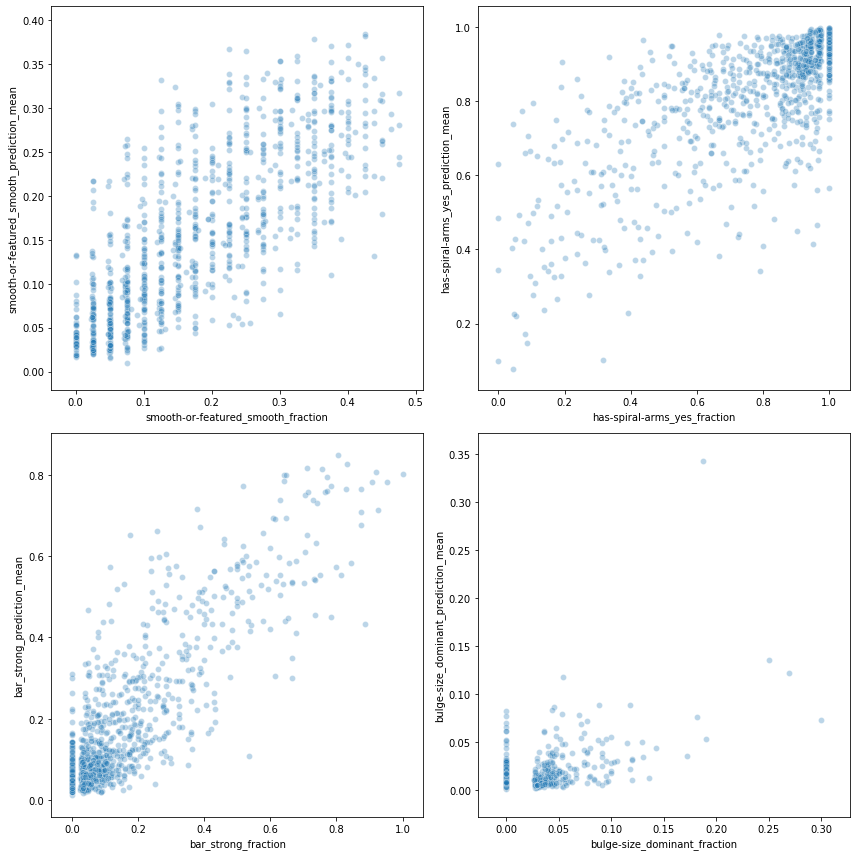

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = [ax for row in axes for ax in row]
for n, q in enumerate(schema.questions):
    a = q.answers[0]
    sns.scatterplot(data=df, x=a.text + '_fraction', y=a.text + '_prediction_mean', ax=axes[n], alpha=0.3)
fig.tight_layout()

In [97]:
for q in schema.questions:
    a = q.answers[0]
    print(a.text, mean_squared_error(df[a.text + '_fraction'], df[a.text + '_prediction_mean']))

smooth-or-featured_smooth 0.006879266039351253
has-spiral-arms_yes 0.031115044088458648
bar_strong 0.011791182064761938
bulge-size_dominant 0.0006681599413066071


In [98]:
assert False

AssertionError: 

In [99]:
# df.to_csv('temp/calibration_predictions.csv', index=False)
# df.to_csv('temp/10k_model_a_predictions.csv', index=False)
df.to_csv('temp/10k_model_b_predictions.csv', index=False)

In [ ]:
assert False

In [ ]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=6, ncols=6):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


In [ ]:


def save_top_n(df, schema, save_dir):
    for question in schema.questions:
        for answer in question.answers:
            fig = show_galaxies(df.sort_values(answer.text + '_prediction_mean', ascending=False)[:36])
            fig.savefig(save_dir + '_' + answer.text + '.png')
            plt.close()

In [ ]:
save_dir = 'results/temp'
save_top_n(df, schema, save_dir)

In [ ]:
assert False  # moove later analysis elsewhere?

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(predictions[:, 0], labels[:, 0] / labels[:, :2].sum(axis=1))
# plt.close()

In [ ]:
matplotlib.get_backend()

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(predictions[:, 4], labels[:, 4] / labels[:, 4:7].sum(axis=1))

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(predictions[:, 5], labels[:, 5] / labels[:, 4:7].sum(axis=1))

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(predictions[:, 6], labels[:, 6] / labels[:, 4:7].sum(axis=1))

In [ ]:
# assert False

In [ ]:
# to check that the right models have been loaded - should be around 40 for smooth, 0-40 for bars
# plt.hist(sim_model.total_votes), sim_model.total_votes.mean()

In [ ]:

def galaxy_posterior_grid(df, schema):
    
    sns.set_context('paper', font_scale=1.5)
    
    scale = 1.5
    
    im_width = 2
    posterior_width = 3
    height = im_width
    
    n_galaxies = len(df)
    n_posteriors = len(schema.answers)
    
    fig = plt.figure(figsize=(scale * (im_width + posterior_width*n_posteriors), (scale * n_galaxies * height)))  # width, height format
    gs = gridspec.GridSpec(len(df) * height, im_width + posterior_width * len(schema.answers))  # y, x format
    image_axes = []
    posterior_axes = []  # (galaxy i.e. row, answer) shape
    
    # create the grid
    for galaxy_n in range(len(df)):
        y_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[y_slice, :im_width]))
        
        temp_galaxy_axes = []
        for answer_n, answer in enumerate(schema.answers):
            x_slice = slice(im_width+answer_n*posterior_width, im_width+(answer_n+1)*posterior_width)
            temp_galaxy_axes.append(plt.subplot(gs[y_slice, x_slice]))
        posterior_axes.append(temp_galaxy_axes)
        
    
    # fill the images
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(df['file_loc'][ax_n], ax)
    
    # fill the posteriors
    for answer_n, answer in enumerate(schema.answers):
        samples, labels, total_votes = get_single_answer_data(df, answer)
        galaxy_axes = [axes[answer_n] for axes in posterior_axes]
        make_predictions.plot_samples(samples, labels, total_votes, fig, galaxy_axes, alpha=0.06)
    
    # fix x limits for comparison
    for row_n, axes in enumerate(posterior_axes):
        for answer_n, ax in enumerate(axes):
            ax.set_xlim([0, 50])
            if row_n == 0:
                ax.set_title(schema.answers[answer_n].text)
        
#     for n in range(len(labels)):
#         multiple_axes[n].set_ylabel(r'$p(k|N, D)$', visible=True)
#         multiple_axes[n].yaxis.set_visible(True)
#         single_axes[n].set_ylabel(r'$p(k|N, w)$', visible=True)
#         single_axes[n].yaxis.set_visible(True)
#         single_axes[n].yaxis.set_major_locator(plt.NullLocator())
#         multiple_axes[n].yaxis.set_major_locator(plt.NullLocator())
#         if n < len(labels) - 1:
#             single_axes[n].xaxis.set_major_locator(plt.NullLocator())
#             multiple_axes[n].xaxis.set_major_locator(plt.NullLocator())
    
# #     if QUESTION == 'bars':
# #         question = 'Bar'
# #     else:
# #         question = 'Smooth'
# #     single_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
# #     multiple_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
#     fig.tight_layout()

    
#     multiple_axes[0].legend(
#         loc='lower center', 
#         bbox_to_anchor=(0.5, 1.1),
#         ncol=1, 
#         fancybox=True, 
#         shadow=False
#     )

    fig.tight_layout()
    return fig

In [ ]:
fig = galaxy_posterior_grid(df[:5], schema)
fig.savefig(save_dir + '/grid.pdf')
fig.savefig(save_dir + '/grid.png')

In [ ]:

def custom_samples_with_galaxies(samples, labels, total_votes, png_locs):
    
    sns.set_context('paper', font_scale=1.5)
    
    im_width = 2
    single_width = 3
    multiple_width = 3
    height = im_width
    
    fig = plt.figure(figsize=(0.8 * len(labels) * height * 2., 0.8 * (im_width + single_width + multiple_width) * 1.75))
    gs = gridspec.GridSpec(len(labels) * height, im_width + single_width + multiple_width)  # y, x format
    image_axes = []
    single_axes = []
    multiple_axes = []
    for galaxy_n in range(len(labels)):
        x_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[x_slice, :im_width]))
        single_axes.append(plt.subplot(gs[x_slice, im_width:im_width+single_width]))
        multiple_axes.append(plt.subplot(gs[x_slice, im_width+single_width:]))
    

#     fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples[:, :1], labels, total_votes, fig, single_axes, alpha=0.06)
    for ax in single_axes:
        ax.set_xlim([0, 50])

    make_predictions.plot_samples(samples, labels, total_votes, fig, multiple_axes, alpha=0.06)
    for ax in multiple_axes:
        ax.set_xlim([0, 50])
        
        
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(png_locs[ax_n], ax)
        
    
    for n in range(len(labels)):
        multiple_axes[n].set_ylabel(r'$p(k|N, D)$', visible=True)
        multiple_axes[n].yaxis.set_visible(True)
        single_axes[n].set_ylabel(r'$p(k|N, w)$', visible=True)
        single_axes[n].yaxis.set_visible(True)
        single_axes[n].yaxis.set_major_locator(plt.NullLocator())
        multiple_axes[n].yaxis.set_major_locator(plt.NullLocator())
        if n < len(labels) - 1:
            single_axes[n].xaxis.set_major_locator(plt.NullLocator())
            multiple_axes[n].xaxis.set_major_locator(plt.NullLocator())
    
#     if QUESTION == 'bars':
#         question = 'Bar'
#     else:
#         question = 'Smooth'
#     single_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
#     multiple_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
    fig.tight_layout()

    single_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    
    multiple_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )

    
    fig.tight_layout()
    return fig

In [ ]:
def plot_galaxy(image_loc, ax, n_examples=10, crop=0):
    im_size = 424
    im = Image.open(image_loc)
#     if QUESTION == 'bars':
#         crop = 120
#     else:
    crop = 35
    cropped_im = im.crop((crop, crop, 424 - crop, 424 - crop))
    ax.imshow(cropped_im)
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


In [ ]:
question = 'has-spiral-arms'
answer = 'yes'
n = 5
samples, labels, total_votes = get_single_answer_data(question, answer)
png_locs = df['file_loc'][:n]

# catalog = sim_model.catalog[selected_slice]

_ = custom_samples_with_galaxies(samples, labels, total_votes, png_locs)

In [ ]:
# fig, axes = plt.subplots(1, 10, figsize=(20, 12))
# for ax_n, ax in enumerate(axes):
#     plot_galaxy(sim_model.catalog.iloc[ax_n]['png_loc'], ax)

In [ ]:
# 1 2

In [ ]:
selected = slice(80, 73, -1)  # smooth

# selected = slice(0, 7)

if QUESTION == 'bars':
    selected = slice(0, 7)

In [ ]:
# np.array(sim_model.model.samples)[selected, :]
# np.array(sim_model.labels)[selected]
# sim_model.catalog['smooth-or-featured_total-votes'][selected]

In [ ]:
fig = custom_samples_with_galaxies(sim_model, selected)
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.pdf'.format(len(np.array(sim_model.labels)[selected]))))

In [ ]:
# be sure to switch label in custom_samples before running this
# fig = custom_samples(np.array(single_sim_model.model.samples)[selected, :1], np.array(single_sim_model.labels)[selected], total_votes=single_sim_model.total_votes)
# fig.savefig(os.path.join(save_dir, 'single_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'single_model_{}.eps'.format(len(np.array(sim_model.labels)[selected]))))

In [ ]:
sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots()
ungrouped_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    sim_model.labels, 
    sim_model.bin_probs)
coverage_df = ungrouped_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()

ungrouped_single_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    single_sim_model.labels, 
    single_sim_model.bin_probs)
single_coverage_df = ungrouped_single_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()


plt.plot(coverage_df['max_state_error'], coverage_df['prediction'], label='MC Model Expects')
plt.plot(single_coverage_df['max_state_error'], single_coverage_df['prediction'], label='Single Model Expects')
plt.plot(single_coverage_df['max_state_error'], coverage_df['observed'], 'k--', label='Actual')

ax.set_xlabel('Max Allowed Vote Error')
ax.set_ylabel('Galaxies Within Max Error')
ax.legend()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))  # must expect 'x' kw arg

ax.set_xlim([0, 15])
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.png'))
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.pdf'))

In [ ]:
ungrouped_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)
ungrouped_single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)

In [ ]:
coverage_df['error'] = coverage_df['prediction'] - coverage_df['observed']
coverage_df['relative_error'] = coverage_df['error'] / coverage_df['observed']
coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_coverage_df.csv'), index=False)
coverage_df.head(20)

In [ ]:
single_coverage_df['error'] = single_coverage_df['prediction'] - single_coverage_df['observed']
single_coverage_df['relative_error'] = single_coverage_df['error'] / single_coverage_df['observed']
single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_single_coverage_df.csv'), index=False)
single_coverage_df.head(20)

TODO - I might consider adding an MSE model as a comparison, to hopefully beat. I think this might be quite similar though. Ideally I can compare this with previous work somehow.

In [ ]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots()
ax.hist(sim_model.abs_rho_error, bins=25)
# ax.axvline(sim_model.mean_abs_rho_error, color='r') 
ax.set_xlim([0, 1.])
ax.set_ylabel('Galaxies')
ax.set_xlabel(r'| Expected $\hat{\rho}$ - observed vote fraction $\frac{k}{N}$ |')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'difference_in_rho.png'))
fig.savefig(os.path.join(save_dir, 'difference_in_rho.pdf'))

In [ ]:
sim_model.abs_rho_error.mean(), single_sim_model.abs_rho_error.mean()

In [ ]:
np.sqrt(sim_model.mean_abs_rho_error), np.sqrt(single_sim_model.mean_abs_rho_error)  

In [ ]:
np.sqrt(sim_model.mean_square_rho_error), np.sqrt(single_sim_model.mean_square_rho_error) # this is the rmse

In [ ]:
# alpha = 0.3
# n_bins = 25

# # dummy for bins
# fig, ax = plt.subplots()
# _, bins, _  = ax.hist(sim_model.labels / sim_model.total_votes, bins=n_bins, alpha=alpha, label=r'Observed $\rho$')
# ax.hist(sim_model.mean_rho_prediction, bins=n_bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')

# fig, ax = plt.subplots()
# sns.set(font_scale=1.)
# sns.set_style('white')

# ax.hist(sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')
# ax.hist(sim_model.labels / sim_model.total_votes, bins=bins, alpha=alpha, label=r'Observed $\rho$')
# ax.legend()
# ax.set_xlim([0., 1.])
# ax.set_ylabel('Galaxies')
# ax.set_xlabel(r'Typical vote fraction $\rho$')
# fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'typical_vote_fraction_distribution.png'))

# This is a repeat of the above histograms

In [ ]:
np.sum(sim_model.mean_rho_prediction > 0.5), np.sum(single_sim_model.mean_rho_prediction > 0.5), np.sum((sim_model.labels / sim_model.total_votes) > 0.5)

In [ ]:
(sim_model.labels / sim_model.total_votes).min(), (sim_model.labels / sim_model.total_votes).max()

In [ ]:
sim_model.mean_rho_prediction.min(), sim_model.mean_rho_prediction.max()

In [ ]:
single_sim_model.mean_rho_prediction.min(), single_sim_model.mean_rho_prediction.max()

In [ ]:
sim_model.total_votes

## Save DataFrame of predictions + catalog (GZ2) for use elsewhere

In [ ]:
import json

In [ ]:
response_df = pd.DataFrame(data={
    'total_votes': sim_model.total_votes, 
    'k': sim_model.labels, 
    'vote_fraction': (sim_model.labels / sim_model.total_votes), 
    'rho_prediction': sim_model.mean_rho_prediction
#     'png_loc': sim_model.catalog.png_loc
})
safe_catalog_cols = list(set(sim_model.catalog.columns.values) - set(['total_votes', 'ra_subject', 'dec_subject']))
df = pd.concat([response_df, sim_model.catalog[safe_catalog_cols]], axis=1)
df['smooth'] = df['vote_fraction'] > 0.5
df['confidence_proxy'] = np.abs(0.5 - df['rho_prediction'])
df['rho_predictions'] = 0
for n in range(len(df)):
    df['rho_predictions'][n] = json.dumps(list(sim_model.model.samples[n, :]))
    df = df.sort_values('confidence_proxy', ascending=False)

In [ ]:
df['rho_predictions']

In [ ]:
df.head()

In [ ]:
df.to_parquet('/data/repos/zoobot/notebooks/{}_test_predictions_and_gz2_catalog.parquet'.format(QUESTION))

### Replicate (ish) Sanchez 2017 ROC Curves

In [ ]:
confusion_matrix((sim_model.labels / sim_model.total_votes) > 0.5, sim_model.mean_rho_prediction > 0.5)

In [ ]:
 1 - ((66 + 99) / (490 + 1845 + 66 + 99))

In [ ]:
 1 - ((189 + 81) / (1858 + 189 + 81 + 372))

In [ ]:
fig, ax = plt.subplots()
sns.set(font_scale=1.2)
sns.set_style('white')

fpr, tpr, _ = roc_curve(df['smooth'], df['rho_prediction'])
ax.plot(fpr, tpr, label='All')
df_low_entropy = df[df['confidence_proxy'] > 0.3]
fpr, tpr, _ = roc_curve(df_low_entropy['smooth'], df_low_entropy['rho_prediction'])
ax.plot(fpr, tpr, label=r'"High Confidence" i.e. $\hat{\rho} < 0.2$ or $\hat{\rho} > 0.8$')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'roc_curve.png'))
fig.savefig(os.path.join(save_dir, 'roc_curve.pdf'))

In [ ]:
len(df), len(df_low_entropy)

### Replicate(ish) Khan 2018 Confusion Matrices

> After selecting the OBJIDs from Table 2 based on the probability thresholds of 0.985 and 0.926 for spirals and ellipticals respectively,

In [ ]:
df.sample(1)

In [ ]:
cdf_array = binom.cdf((df['total_votes'] / 2.).astype(int), df['total_votes'], df['rho_prediction'])

In [ ]:
(df['total_votes'] / 2.).astype(int).sample(10)

In [ ]:
df['total_votes'].sample(10)

In [ ]:
df['rho_prediction'].sample(10)

In [ ]:
plt.hist(cdf_array, bins=30)

In [ ]:
binom.cdf(20, 40, 0.88)

In [ ]:
sum(1 - cdf_array > 0.985)

In [ ]:
sum(cdf_array > 0.926)

In [ ]:
high_prob_df = df[(cdf_array < (1 - 0.985)) | (cdf_array > 0.926)]

In [ ]:
len(high_prob_df)

In [ ]:
if QUESTION == 'smooth':
    spiral_pc_to_keep = 516 / 6677
    n_spirals = int(len(df) * spiral_pc_to_keep)
    elliptical_pc_to_keep = 550 / 5904
    n_ellipticals = int(len(df) * elliptical_pc_to_keep)
    print(spiral_pc_to_keep, n_spirals, elliptical_pc_to_keep, n_ellipticals)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:n_spirals],
        df.sort_values('rho_prediction', ascending=False)[:n_ellipticals]
    ])
if QUESTION == 'bars':
    n_to_keep = int(len(df) * 0.08)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:int(n_to_keep/2)],
        df.sort_values('rho_prediction', ascending=False)[:int(n_to_keep/2)]
    ])



In [ ]:
high_prob_df.sample(20)

In [ ]:
confusion_matrix(high_prob_df['vote_fraction'] >= 0.5, high_prob_df['rho_prediction'] >= 0.5)

In [ ]:
error = high_prob_df[~(high_prob_df['vote_fraction'] > 0.5) & (high_prob_df['rho_prediction'] > 0.5)]

In [ ]:
error

In [ ]:
error['vote_fraction'] > 0.5, error['rho_prediction'] > 0.5

In [ ]:
img = Image.open(error.iloc[0]['png_loc'])
plt.imshow(img)
fontdict = {'size': 16, 'color': 'white'}
plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.80', fontdict=fontdict)
plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.50', fontdict=fontdict)
plt.axis('off')
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.png'))
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.eps'))

In [ ]:
# img = Image.open(error.iloc[1]['png_loc'])
# plt.imshow(img)
# fontdict = {'size': 16, 'color': 'white'}
# plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.13', fontdict=fontdict)
# plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.54', fontdict=fontdict)
# plt.axis('off')
# plt.savefig(os.path.join(save_dir, 'high_prob_error_1.png'))
# plt.savefig(os.path.join(save_dir, 'high_prob_error_1.eps'))

In [ ]:
confusion_matrix(df['vote_fraction'][:int(len(df) / 2)] > 0.5, df['rho_prediction'][:int(len(df) / 2)] > 0.5)

In [ ]:
if QUESTION == 'smooth':
    labels = ['Smooth', 'Featured']
    
#     cm = np.array([[ 232,    2], [   0, 191]])
#     name = 'confusion_matrix_high_confidence'
    
    cm = np.array([[ 490,   66],
       [  99, 1845]])
    name = 'confusion_matrix'
    
if QUESTION == 'bars':
    labels = ['No Bar', 'Bar']
    cm = np.array([[100,    0], [   0,   100]])
    name = 'confusion_matrix_high_confidence'
    
#     cm = np.array([[1858,    81], [   189,   372]])
#     name = 'confusion_matrix'

sns.set(font_scale=3.)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False, square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, '{}.png'.format(name)))
fig.savefig(os.path.join(save_dir, '{}.pdf'.format(name)))

In [ ]:
1 - (8 / (1159 + 83 + 8))

In [ ]:
# sim_model.export_performance_metrics(save_dir)

In [ ]:
# Draw a galaxy, infer a range of p, redraw, and measure accuracy - work in progress

### Plot other standard acquisition visualisations

In [ ]:
new_acquisition_viz = False
if new_acquisition_viz:
    image_locs = sim_model.catalog['png_loc']
    images = np.stack([np.array(Image.open(loc)) for loc in image_locs])
    assert images.shape == (2500, 424, 424, 3)
    acquisition_utils.save_acquisition_examples(images, sim_model.mutual_info, 'mutual_info', save_dir)

In [ ]:
# fig, row = plt.subplots(ncols=3, figsize=(12, 4))

In [ ]:
# row = sim_model.acquisition_vs_volunteer_votes(row)

### Visualise Selection of Catalog Features w.r.t. Acquisition Function

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
gs = gridspec.GridSpec(6, 5, figure=fig)

#### Smooth Votes

In [ ]:
ax0 = plt.subplot(gs[:4, :])
sns.scatterplot(
    np.array(sim_model.catalog['smooth-or-featured_smooth_fraction'] * 40).astype(int),
    sim_model.model.acquisitions, hue=np.array(sim_model.model.acquisitions) > np.array(sim_model.model.acquisitions[103]),
    ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Smooth Votes')
ax0.legend([r'Top 10% $\mathcal{I}$', r'Bottom 90% $\mathcal{I}$'])

In [ ]:
ax1 = plt.subplot(gs[4:, :])
ax1.hist(np.array(sim_model.labels * 40).astype(int), density=True, alpha=0.4)
ax1.hist(np.array(sim_model.labels * 40).astype(int)[:200], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')

In [ ]:
plt.savefig(os.path.join(save_dir, 'temp.png'))

#### Redshift

In [ ]:
fig, ax = plt.subplots()
sns.jointplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], kind='kde')
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.jointplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], kind='kde', ax=ax0)
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.jointplot(sim_model.catalog['redshift'], sim_model.model.acquisitions, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Redshift')

In [ ]:
ax1 = plt.subplot(gs[4:, :])

ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
# ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')
# TODO sort by mutual information

### Below here is only relevant for DECALS, with extra questions. TODO update with GZ2 merger options?

In [ ]:
assert False

In [ ]:
merger_strs

In [ ]:
merger_label = 'merging_major-disturbance'

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(sim_model.catalog[merger_label], sim_model.model.mutual_info, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel(merger_label)

In [ ]:
_ = plt.hist(sim_model.catalog[merger_label], bins=40)

In [ ]:
featured_no_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] == 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]
featured_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] > 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]

In [ ]:
featured_no_merger.mean()

In [ ]:
featured_merger.mean()

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.hist(featured_no_merger, alpha=0.3, density=True)

In [ ]:
ax.hist(featured_merger, alpha=0.3, density=True)

In [ ]:
fig

In [ ]:
ax = sns.scatterplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info, 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[103])
ax.set_xlim([0, 14.5])

In [ ]:
sns.regplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig

In [ ]:
has-spiral-arms_yes
spiral-winding_prediction-encoded

In [ ]:
sns.scatterplot(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    sim_model.model.mutual_info[sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[100])

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
for merger_label in merger_strs:
    print('\n' + merger_label)
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] > 1].mean())
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] == 1].mean())

In [ ]:
data = [
    {'Volunteer Response': 'Merging', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_both-v1'] > 1].mean()},
    {'Volunteer Response': 'Major Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_major-disturbance'] > 1].mean()},
    {'Volunteer Response': 'Minor Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_minor-disturbance'] > 1].mean()},
    {'Volunteer Response': 'No Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_none'] > 20].mean()}
    ]

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots()
ax = sns.barplot(data=df, y='Volunteer Response', x='Mean Mutual Information', ax=ax)
ax.set_xlim([0.2, 0.36])
fig.tight_layout()

In [ ]:
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) > 0].mean())
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) == 0].mean())

In [ ]:
plt.hist(sim_model.catalog['merging_tidal-debris-v1'], bins=40)